In [1]:
# %matplotlib widget

import sys
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from receiver import ReceiverBLE
from filters import decimating_fir_filter, single_pole_iir_filter
from demodulation import demodulate_frequency, symbol_sync, binary_slicer, simple_squelch
from data_io import read_iq_data
from visualisation import plot_complex_time, plot_periodograms, plot_payload
from modulation import gaussian_fir_taps
from snr_related import add_awgn_signal_present


plt.close("all")

# Testing matched filtering on demodulation process

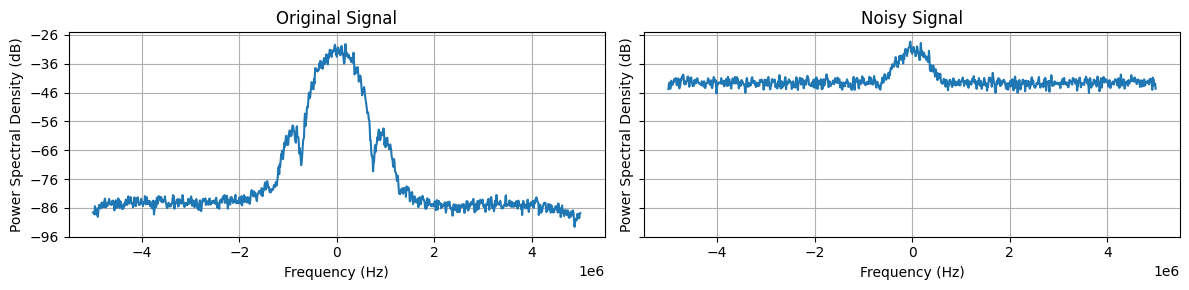

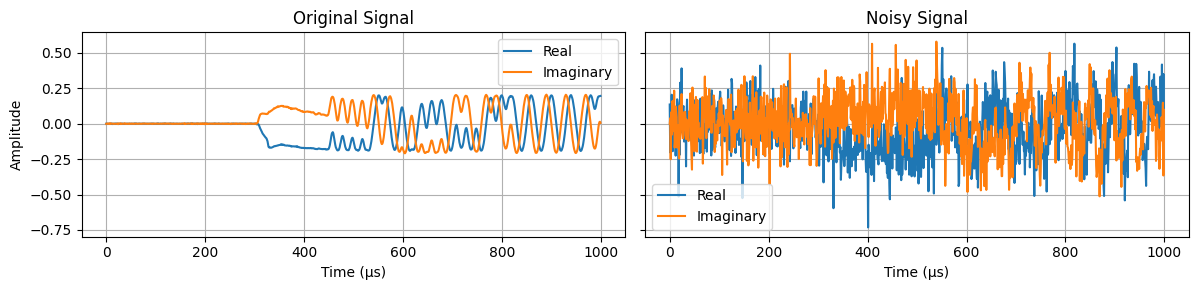

In [2]:
fs = 10e6  # Hz
sps = 10
Rb = fs / sps  # Baud rate
filename = "BLE_0dBm.dat"  # Open BLE file
iq_samples = read_iq_data(f"../../capture_nRF/data/new/{filename}")
fsk_deviation_ble: float = 250e3  # Hz

desired_SNR = 0  # dB
signal_present = (4000, 14000)

iq_samples_noisy = add_awgn_signal_present(iq_samples, desired_SNR, sample_interval=signal_present)

figsize = (12, 3)
plot_periodograms(
    [iq_samples, iq_samples_noisy],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=figsize,
    NFFT=1024,
    horizontal=True,
)
time_interval = (3000, 4000)
# time_interval = (0, -1)
plot_complex_time(
    [iq_samples[time_interval[0] : time_interval[1]], iq_samples_noisy[time_interval[0] : time_interval[1]]],
    fs=fs,
    titles=["Original Signal", "Noisy Signal"],
    figsize=figsize,
    horizontal=True,
)

## Demodulation process at receiver
Applying matched filtering before frequency demodulating yields better results

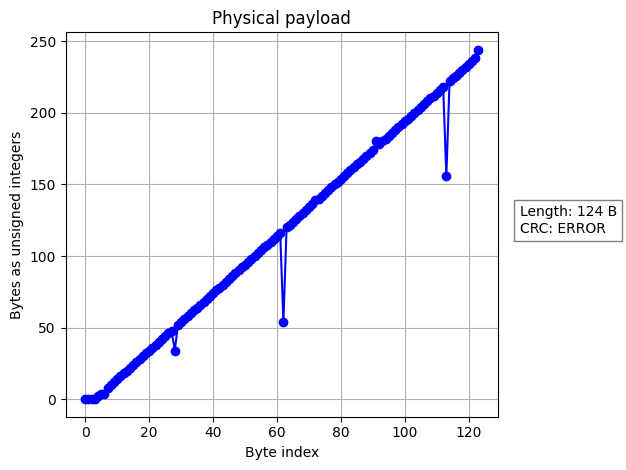

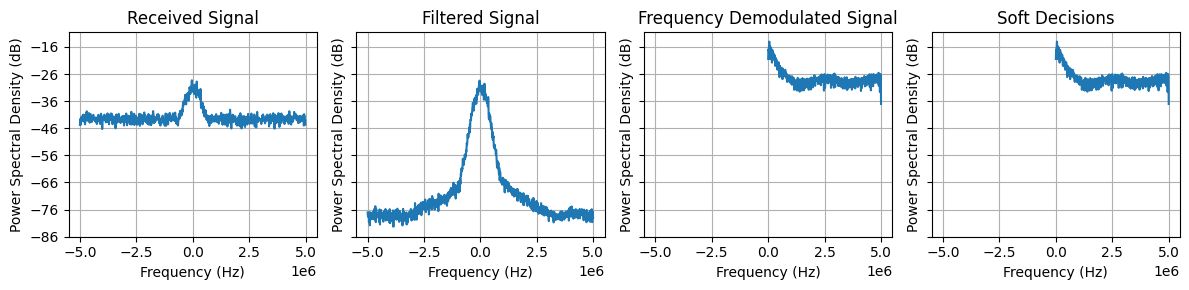

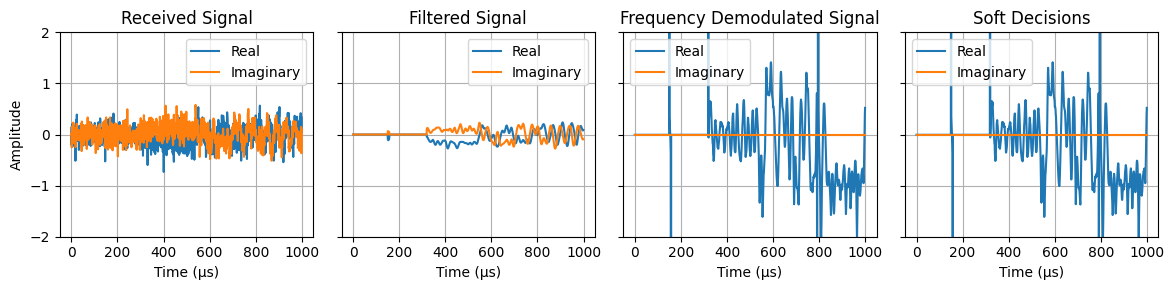

In [3]:
butterworth_filter = 2
match_filter_after_frequency = False
if butterworth_filter == 1:
    # Low pass filter
    iq_samples_filtered = decimating_fir_filter(
        iq_samples_noisy,
        decimation=1,
        gain=1,
        fs=fs,
        cutoff_freq=1e6,
        transition_width=100003,
        window="hamming",
    )
elif butterworth_filter == 2:
    # Matched filtering (Gausian FIR taps)
    # Generate Gaussian taps and convolve with rectangular window
    gauss_taps = gaussian_fir_taps(sps=sps, ntaps=sps, bt=0.5)
    gauss_taps = scipy.signal.correlate(gauss_taps, np.ones(sps))
    gauss_taps /= np.sum(gauss_taps)  # Unitary gain
    # frequency_modulated_gaussian_taps = modulate_frequency(gauss_taps, 250e3, fs)
    iq_samples_filtered = scipy.signal.correlate(iq_samples_noisy, gauss_taps, mode="full")
else:
    iq_samples_filtered = iq_samples_noisy

# Simple squelch (power)
iq_samples_filtered = simple_squelch(iq_samples_filtered, threshold_dB=-20, alpha=0.3)

# Frequency demodulation
freq_samples = demodulate_frequency(iq_samples_filtered, gain=(fs) / (2 * np.pi * fsk_deviation_ble))
freq_samples -= single_pole_iir_filter(freq_samples, alpha=160e-6)

if match_filter_after_frequency:
    # Matched filtering (Gausian FIR taps)
    # Generate Gaussian taps and convolve with rectangular window
    gauss_taps = gaussian_fir_taps(sps=sps, ntaps=sps, bt=0.5)
    # gauss_taps = scipy.signal.correlate(gauss_taps, np.ones(sps))
    gauss_taps /= np.sum(gauss_taps)  # Unitary gain
    matched_filtered = scipy.signal.correlate(freq_samples, gauss_taps, mode="full")
else:
    matched_filtered = freq_samples


# Symbol synchronisation
bit_samples = symbol_sync(matched_filtered, sps=sps)
bit_samples = binary_slicer(bit_samples)
receiver_ble = ReceiverBLE(fs=fs)
# bit_samples = receiver_ble.demodulate(iq_samples)

# ---- Plots ----
received_packets: list[dict] = receiver_ble.process_phy_packet(bit_samples)
if received_packets:
    plot_payload(received_packets[0])

plot_periodograms(
    [
        iq_samples_noisy,
        iq_samples_filtered,
        freq_samples,
        matched_filtered,
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal",
        "Frequency Demodulated Signal",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    NFFT=1024,
    horizontal=True,
)

plot_complex_time(
    [
        iq_samples_noisy[time_interval[0] : time_interval[1]],
        iq_samples_filtered[time_interval[0] : time_interval[1]],
        freq_samples[time_interval[0] : time_interval[1]],
        matched_filtered[time_interval[0] : time_interval[1]],
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal",
        "Frequency Demodulated Signal",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    ylim=(-2, 2),
    horizontal=True,
)

## Band-pass Based Matched Filtering

Apply band-pass matched filtering to the expected frequency at binary 1 and the expected frequency at binary 0 (centre frequency $ \pm \Delta_{FSK} = 250$ kHz). Compare the squared magnitudes of the resulting complex convolution for soft decision-making.

Based on:  
- [FSK Signals Demodulation – WJ Tech Notes](https://www.rfcafe.com/references/articles/wj-tech-notes/fsk-signals-demodulation-v7-5.pdf)  
- [FSK Demodulation & Bit Timing Recovery – DSP Stack Exchange](https://dsp.stackexchange.com/questions/30793/fsk-demodulation-bit-timing-recovery)  



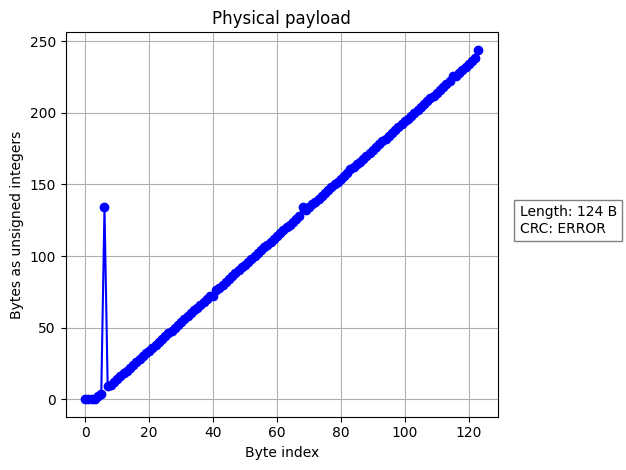

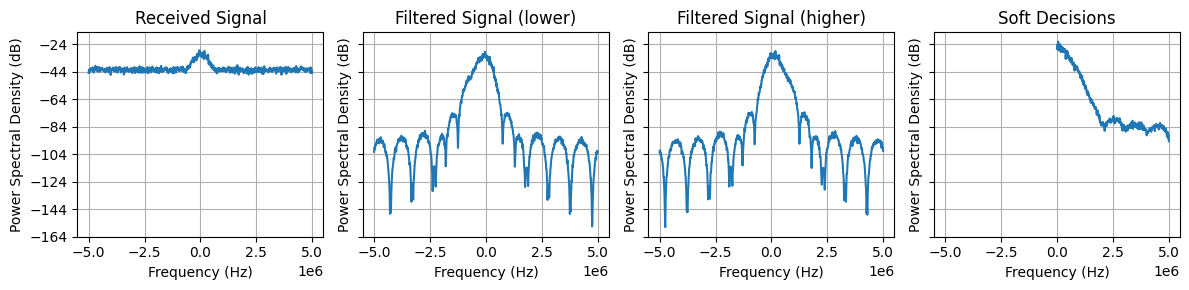

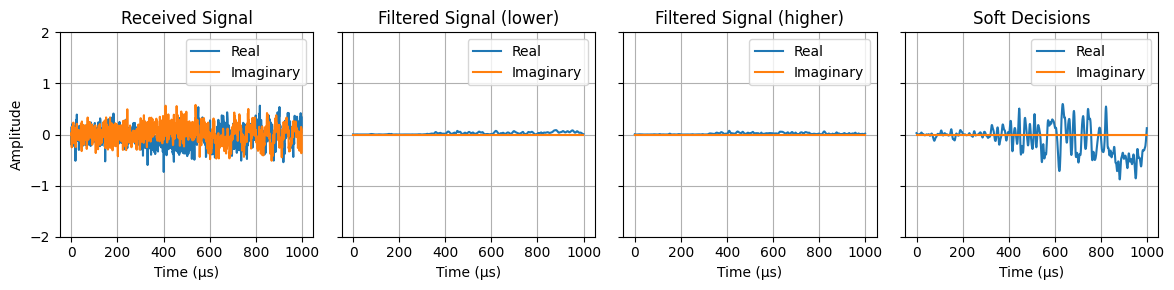

In [6]:
# Matched filtering (Gausian FIR taps) (repeating code for clarity)
# Generate Gaussian taps and convolve with rectangular window
gauss_taps = gaussian_fir_taps(sps=sps, ntaps=sps, bt=0.5)
gauss_taps = scipy.signal.convolve(gauss_taps, np.ones(sps))
gauss_taps /= np.sum(gauss_taps)  # Unitary gain

complex_exp = np.exp(1j * 2 * np.pi * fsk_deviation_ble * np.arange(len(gauss_taps)) / fs)
gauss_bandpass_lower = gauss_taps / complex_exp
gauss_bandpass_higher = gauss_taps * complex_exp

# Band-pass filter (complex signal, complex filter, complex output)
iq_samples_lower = scipy.signal.convolve(iq_samples_noisy, gauss_bandpass_lower, mode="full")
iq_samples_higher = scipy.signal.convolve(iq_samples_noisy, gauss_bandpass_higher, mode="full")

# Magnitude squared
iq_samples_lower_square = iq_samples_lower * np.conj(iq_samples_lower)
iq_samples_higher_square = iq_samples_higher * np.conj(iq_samples_higher)

# Subtract to obtain soft decisions
soft_decisions_subtracted = np.real(iq_samples_higher_square - iq_samples_lower_square)
soft_decisions_subtracted /= np.max(soft_decisions_subtracted)

# Symbol synchronisation
bit_samples = symbol_sync(soft_decisions_subtracted, sps=sps)
bit_samples = binary_slicer(bit_samples)

# ---- Plots ----
received_packets: list[dict] = receiver_ble.process_phy_packet(bit_samples)
if received_packets:
    plot_payload(received_packets[0])

plot_periodograms(
    [
        iq_samples_noisy,
        iq_samples_lower,
        iq_samples_higher,
        soft_decisions_subtracted,
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal (lower)",
        "Filtered Signal (higher)",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    NFFT=1024,
    horizontal=True,
)

plot_complex_time(
    [
        iq_samples_noisy[time_interval[0] : time_interval[1]],
        iq_samples_lower_square[time_interval[0] : time_interval[1]],
        iq_samples_higher_square[time_interval[0] : time_interval[1]],
        soft_decisions_subtracted[time_interval[0] : time_interval[1]],
    ],
    fs=fs,
    titles=[
        "Received Signal",
        "Filtered Signal (lower)",
        "Filtered Signal (higher)",
        "Soft Decisions",
    ],
    figsize=(12, 3),
    ylim=(-2, 2),
    horizontal=True,
)

# Encapsulation of demodulation procedures in Receiver classes

instantaneous
pass band


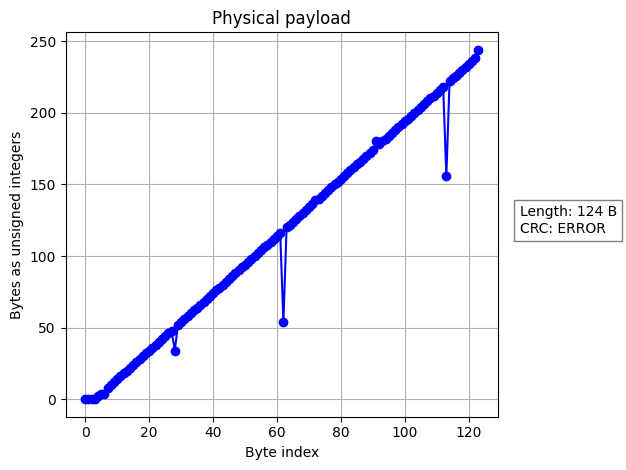

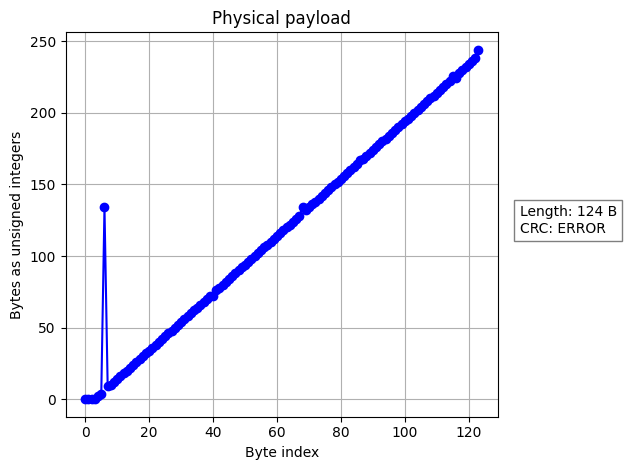

In [5]:
received_packets_instantaneous = receiver_ble.demodulate_to_packet(
    iq_samples_noisy,
    demodulation_type="INSTANTANEOUS_FREQUENCY",
)
received_packets_band_pass = receiver_ble.demodulate_to_packet(
    iq_samples_noisy,
    demodulation_type="BAND_PASS",
)

if received_packets_instantaneous:
    print("instantaneous")
    plot_payload(received_packets_instantaneous[0])

if received_packets_band_pass:
    print("pass band")
    plot_payload(received_packets_band_pass[0])